# 线性回归

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

In [14]:
# 从源文件中加载数据，并输出查看数据的各项特征
lines = np.loadtxt('data/USA_Housing.csv',delimiter=',',dtype='str')
header = lines[0]
lines = lines[1:].astype(float)

print('数据特征：',','.join(header[:]))
print('数据标签：',header[-1])
print('数据总条数：',len(lines))

数据特征： Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
数据标签： Price
数据总条数： 5000


In [15]:
# 划分训练集与测试集
ratio = 0.8
split = int(len(lines) * ratio)
lines = np.random.permutation(lines)
train,test = lines[:split],lines[split:]

# 数据标准化
scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

# 划分输入和标签
x_train,y_train = train[:,:-1],train[:,-1].flatten()
x_test,y_test = test[:,:-1],test[:,-1].flatten()

In [16]:
# 在X矩阵最后添加一列1，代表常数项
X = np.concatenate([x_train,np.ones((len(x_train),1))],axis = 1)
# @表示矩阵相乘，X.T表示矩阵的转置，np.linalg.inv函数可以计算矩阵的逆
theta = np.linalg.inv(X.T @ X) @ X.T @ y_train
print('回归系数：',theta)

回归系数： [ 6.51713859e-01  4.60833536e-01  3.46753244e-01  7.72084461e-03
  4.26736986e-01 -7.05247340e-15]


In [17]:
# 在测试集上使用回归系数进行预测
X_test = np.concatenate([x_test,np.ones((len(x_test),1))],axis = -1)
y_pred = X_test @ theta

In [18]:
# 计算真实值和测量值之间的RMSE
rmse_loss = np.sqrt(np.square(y_test - y_pred).mean())
print('RMSE:',rmse_loss)

RMSE: 0.2948124296843913


# 使用sklearn中的线性回归模型

In [19]:
from sklearn.linear_model import LinearRegression

# 初始化线性回归模型
linreg = LinearRegression()

# LinearRegression的方法中已经考虑到了线性回归的常数项，所以不用拼接1
linreg.fit(x_train,y_train)

# coef_是训练得到的回归系数，intercept_是常数项
print('回归系数：',linreg.coef_,linreg.intercept_)
y_pred = linreg.predict(x_test)

# 计算预测值和真实值之间的RMSE
rmse_loss = np.sqrt(np.square(y_test - y_pred).mean())
print('RMSE:',rmse_loss)

回归系数： [0.65171386 0.46083354 0.34675324 0.00772084 0.42673699] -7.079796694312454e-15
RMSE: 0.2948124296843913


# SGD算法

In [27]:
# 随机划分数据集，生产批量函数
# 该函数每次返回大小为batch_size的批量
# x和y分别为输入和标签
# 若shuffle = TRUE，则每次遍历时会将数据重新划分

def batch_generator(x,y,batch_size,shuffle=True):
    # 批量计数器
    batch_count = 0
    if shuffle:
        # 随机生成0到len(x)-1的下标
        idx = np.random.permutation(len(x))
        x = x[idx]
        y = y[idx]
    while True:
        start = batch_count * batch_size
        end = min(start + batch_size, len(x))
        if start >= end:
            # 已经遍历一遍，结束生成
            break
        batch_count += 1
        yield x[start:end],y[start:end]

def SGD(num_epoch,learning_rate,batch_size):
    # 拼接原始矩阵
    X = np.concatenate([x_train,np.ones((len(x_train),1))],axis=-1)
    X_test = np.concatenate([x_test,np.ones((len(x_test),1))],axis=-1)
    # 随机初始化参数
    theta = np.random.normal(size=X.shape[1])

    # 随机梯度下降
    # 为了观察迭代过程，我们记录每一次迭代后再训练集和测试集上的均方根误差
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        # 初始化批量生成器
        batch_g = batch_generator(X,y_train,batch_size,shuffle=True)
        train_loss = 0
        for x_batch,y_batch in batch_g:
            # 计算梯度
            grad = x_batch.T @ (x_batch @ theta - y_batch)
            # 更新参数
            theta = theta - learning_rate * grad / len(x_batch)
            # 累加平方误差
            train_loss += np.square(x_batch @ theta - y_batch).sum()
        # 计算训练和测试误差
        train_loss = np.sqrt(train_loss / len(X))
        train_losses.append(train_loss)
        test_loss = np.sqrt(np.square(X_test @ theta - y_test).mean())
        test_losses.append(test_loss)
    # 输出结果，绘制训练曲线
    print('回归系数：',theta)
    return theta,train_losses,test_losses

In [46]:
# 设置训练轮数，学习率，批量大小
num_epoch = 20
learning_rate = 0.01
batch_size = 32

# 设置随机种子
np.random.seed(2023)

_,train_losses,test_losses = SGD(num_epoch,learning_rate,batch_size)

回归系数： [ 6.52080715e-01  4.61754879e-01  3.46330790e-01  6.14978995e-03
  4.26288266e-01 -1.94614807e-04]


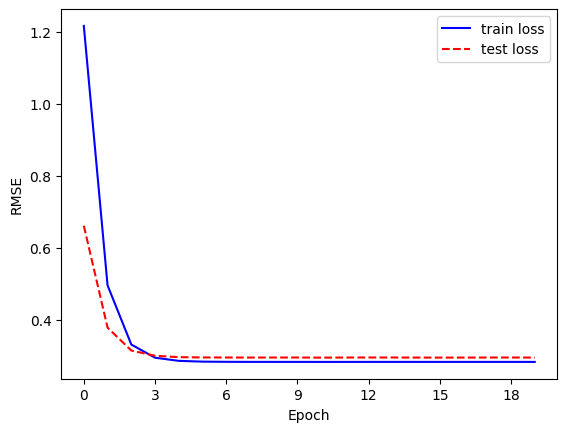

In [51]:
# 将损失函数关于轮数的关系制图
plt.plot(np.arange(num_epoch),train_losses,color='blue',label='train loss')
plt.plot(np.arange(num_epoch),test_losses,color='red',ls='--',label='test loss')

# 由于epoch是整数，把图中的横坐标也设为整数
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

回归系数： [0.65748616 0.45590902 0.35345389 0.01479355 0.42299245 0.01113646]
回归系数： [ 0.55522425  0.33205621  0.5826653  -0.23596453  0.3593729   0.0661958 ]


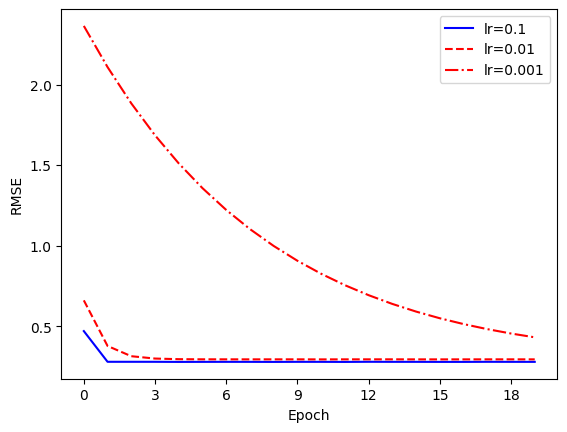

In [52]:
# 观察学习率对迭代的影响
_,loss1,_ = SGD(num_epoch=20,learning_rate = 0.1,batch_size=32)
_,loss2,_ = SGD(num_epoch=20,learning_rate = 0.001,batch_size=32)

plt.plot(np.arange(num_epoch),loss1,color='blue',label='lr=0.1')
plt.plot(np.arange(num_epoch),test_losses,color='red',ls='--',label='lr=0.01')
plt.plot(np.arange(num_epoch),loss2,color='red',ls='-.',label='lr=0.001')

# 由于epoch是整数，把图中的横坐标也设为整数
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

回归系数： [-2.82817601e+85 -1.05422797e+85  9.67767480e+85  9.56145591e+85
  1.10656517e+86  5.53345438e+85]
最终损失： 9.415837351679557e+87


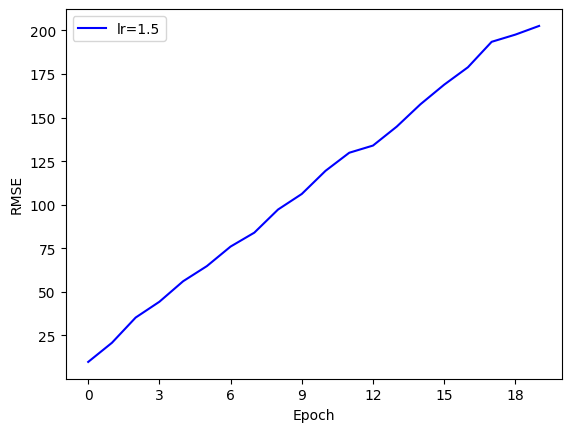

In [55]:
_,loss3,_ = SGD(num_epoch=20,learning_rate = 1.5,batch_size=32)
print('最终损失：',loss3[-1])
plt.plot(np.arange(num_epoch),np.log(loss3),color='blue',label='lr=1.5')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Others
### np.random.permutation() 
- https://blog.csdn.net/qq_45288176/article/details/125117426
- 就是按照给定列表生成一个打乱后的随机列表

### yield
- https://blog.csdn.net/qq_41554005/article/details/119940983

### '@'矩阵相乘
- https://blog.csdn.net/amuro_ray027/article/details/129798059

### np.arange()
- 函数返回一个有终点和起点的固定步长的排列
- https://blog.csdn.net/qq_41550480/article/details/89390579

### python数据可视化
- https://blog.csdn.net/J__aries/article/details/117425907